# Hierarchical forgetting Q-learning

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='ticks', font_scale=1.5)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

np.random.seed(364)

In [2]:
# generate data
num_arms = 3
p_rew = np.array([0.1, 0.2, 0.7])
num_steps = 200
len_hist = 5
alpha_exploit = 0.99
beta_exploit = 10
alpha_explore = 0.8
beta_explore = 5
coef_exploit = np.array([alpha_exploit * (1 - alpha_exploit) ** k * beta_exploit for k in range(len_hist)])
coef_explore = -np.array([alpha_explore * (1 - alpha_explore) ** k * beta_explore for k in range(len_hist)])
coefs = np.vstack((coef_exploit, coef_explore))

features = []
observations = []
labels = []
x = np.zeros((num_arms, len_hist))
int_idx = 0
for i in range(num_steps):
    v = x @ coefs[int_idx]
    pi = np.exp(v) / np.sum(np.exp(v), keepdims=True)
    a = np.random.choice(num_arms, p=pi)
    x_new = np.zeros(num_arms)
    if np.random.uniform() < p_rew[a]:
        x_new[a] += 1
        
    features.append(x)
    observations.append(a)
    labels.append(int_idx)

    x = np.hstack((x_new[:, None], x[:, :-1]))
    if (i + 1) % 20 == 0:
        int_idx = np.abs(int_idx - 1)
features = np.array(features)
observations = np.array(observations)
labels = np.array(labels)

In [3]:
### problem data
xs = features  # ndarray: dataset features
ys = []  # ndarray: dataset observations
for a in observations:
    a_vec = np.zeros(xs.shape[1])
    a_vec[a] += 1
    ys.append(a_vec)
ys = np.array(ys)
m = xs.shape[0]  # int: number of samples in the dataset
n = xs.shape[2]

### hyperparameters
eps = 1e-6  # float: termination criterion

### P-problem
K = 2  # int: number of latent factors
thetas = []  # list of cp.Variable objects: model parameters
r = []  # list of cp.Expression objects: loss functions
for k in range(K):
    thetas.append(cp.Variable(n))
    r.append(
        cp.hstack([-(xs[i] @ thetas[-1] @ ys[i] - cp.log_sum_exp(xs[i] @ thetas[-1])) for i in range(m)])
    )

ztil = cp.Parameter((m, K), nonneg=True)
Pobj = cp.sum(cp.diag(ztil @ cp.vstack(r)))
Preg = 0  # cp.Expression: regularization on model parameters
Pconstr = [
    thetas[0] >= 0,
    cp.diff(thetas[0]) <= 0,
    thetas[1] <= 0,
    cp.diff(thetas[1]) >= 0
]  # list of cp.Constraint objects: model parameter constraints
Pprob = cp.Problem(cp.Minimize(Pobj + Preg), Pconstr)
assert Pprob.is_dcp()

### F-problem
rtil = cp.Parameter((K, m))
z = cp.Variable((m, K))
Fobj = cp.sum(cp.diag(z @ rtil))
lbd = cp.Parameter(nonneg=True)  # regularization weight
Freg = lbd * cp.sum(cp.kl_div(z[:-1], z[1:]))  # cp.Expression: regularization on latent factors
Fconstr = [z >= 0, z <= 1, cp.sum(z, axis=1) == 1]
Fprob = cp.Problem(cp.Minimize(Fobj + Freg), Fconstr)
assert Fprob.is_dcp()

### solve, terminate when the F- and P-objective converge
def solve(p):
    print(f"Solve with labmda = {p}.")
    lbd.value = p
    i = 0
    while True:
        i += 1
        if ztil.value is None:
            ztil.value = np.random.dirichlet(np.ones(K), size=m)
        else:
            ztil.value = np.abs(z.value)
        Pprob.solve()
    
        rtil.value = cp.vstack(r).value
        Fprob.solve()
    
        print(f"Iteration {i}: P-problem value: {Pobj.value}, F-problem value: {Fobj.value}, gap: {np.abs(Pobj.value - Fobj.value)}.")
        if np.abs(Pobj.value - Fobj.value) < eps:
            break
    return np.array([theta.value for theta in thetas]), z.value

thetas_noreg, z_noreg = solve(p=0)
thetas_reg, z_reg = solve(p=1)

Solve with labmda = 0.
Iteration 1: P-problem value: 216.32915938802864, F-problem value: 196.75934190274984, gap: 19.569817485278804.
Iteration 2: P-problem value: 113.38248933574127, F-problem value: 112.53058323464191, gap: 0.8519061010993596.
Iteration 3: P-problem value: 109.69845285488103, F-problem value: 109.69842268732943, gap: 3.0167551599902254e-05.
Iteration 4: P-problem value: 109.6974917460416, F-problem value: 109.69749028319193, gap: 1.462849681388434e-06.
Iteration 5: P-problem value: 109.69750655930484, F-problem value: 109.6975054474864, gap: 1.1118184346514681e-06.
Iteration 6: P-problem value: 109.6974898545873, F-problem value: 109.69748821349093, gap: 1.6410963752377938e-06.
Iteration 7: P-problem value: 109.6975019523854, F-problem value: 109.69750092834617, gap: 1.0240392214200256e-06.
Iteration 8: P-problem value: 109.69808423984881, F-problem value: 109.69808331647846, gap: 9.233703508471081e-07.
Solve with labmda = 1.
Iteration 1: P-problem value: 109.697534

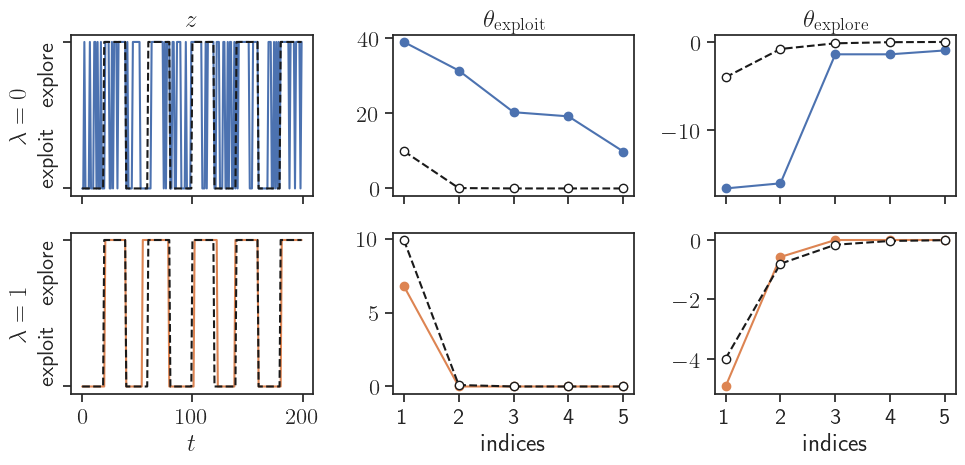

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

colors = ['C0', 'C1']
for r_idx, (params, factors) in enumerate(zip([thetas_noreg, thetas_reg], [z_noreg, z_reg])):
    axs[r_idx, 0].plot(labels, linestyle='dashed', color='k', zorder=10)
    axs[r_idx, 0].plot(np.argmax(factors, axis=-1), color=colors[r_idx])
    
    for k in range(K):
        axs[r_idx, k + 1].plot(coefs[k], linestyle='dashed', 
                               marker='o', markerfacecolor='w', color='k', zorder=10)
        axs[r_idx, k + 1].plot(params[k], marker='o', color=colors[r_idx])

for r_idx in range(axs.shape[0]):
    axs[r_idx, 0].yaxis.get_majorticklabels()[0].set_verticalalignment("bottom")
    axs[r_idx, 0].yaxis.get_majorticklabels()[1].set_verticalalignment("top")
    axs[r_idx, 0].set_yticks([0, 1])
    axs[r_idx, 0].set_yticklabels(['exploit', 'explore'], rotation=90)

    axs[r_idx, 0].set_xticks([0, 100, 200])
    axs[r_idx, 1].set_xticks(np.arange(0, n))
    axs[r_idx, 1].set_xticklabels(np.arange(1, n + 1))
    axs[r_idx, 2].set_xticks(np.arange(0, n))
    axs[r_idx, 2].set_xticklabels(np.arange(1, n + 1))

for c_idx in range(axs.shape[-1]):
    axs[0, c_idx].set_xticklabels([])

axs[1, 0].set_xlabel(r'$t$')
axs[1, 1].set_xlabel('indices')
axs[1, 2].set_xlabel('indices')

axs[0, 0].set_title(r'$z$')
axs[0, 1].set_title(r"$\theta_{\rm exploit}$")
axs[0, 2].set_title(r"$\theta_{\rm explore}$")

axs[0, 0].set_ylabel(r'$\lambda = 0$')
axs[1, 0].set_ylabel(r'$\lambda = 1$')

plt.tight_layout()

fig.savefig('../figures/hier_forget_q_learning.pdf', bbox_inches='tight')

In [5]:
for p, factor in zip([0, 1], [z_noreg, z_reg]):
    acc = np.sum(np.argmax(factor, axis=-1) == labels) / len(labels)
    print(f'Factor identification accuracy (lambda = {p}): {acc}.')

Factor identification accuracy (lambda = 0): 0.71.
Factor identification accuracy (lambda = 1): 0.93.
